<a href="https://colab.research.google.com/github/simonezxm/STAT-37601-Machine-Learning/blob/main/%E2%80%9CLSTM_EXP_pytorch_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [194]:
import os

# Check if you're on Google drive or on your own machine.
# Get path to your data.
if ('google' in str(get_ipython())):
    from google.colab import drive
    drive.mount('ME', force_remount=True)
    #predir='/content/ME/My Drive/'
    predir='/content/ME/MyDrive/Machine_learning/'
else:
    predir='/Users/amit/Google Drive/'
   
import torch
import numpy as np

# Torch functions 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import collections
import pickle
import argparse
from random import shuffle
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pylab  as plt
#%matplotlib inline


# Folder with course data
datadir=predir
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)
import time
import numpy as np



Mounted at ME
cuda:0


# Parameters used in code

In [195]:
parser = argparse.ArgumentParser()
parser.add_argument('--data_dir', default=datadir)
parser.add_argument('--save_dir', default='./')
# Dimension of hidden layer variables h and c
parser.add_argument('--num_units', default=128*2)
parser.add_argument('--batch_size', default=64)
# Number of steps in each batch for training
parser.add_argument('--num_steps', default=75)
parser.add_argument('--num_epochs', default=3)
# Time step
parser.add_argument('--lr', default=0.002)
# Number of possible inputs/outputs 
parser.add_argument('--num_chars')
parser.add_argument('--num_batches',default=20)
args, unparsed = parser.parse_known_args()

In [196]:
def timer(start, end):
    hrs, rem = divmod(end-start, 3600)
    mins, secs = divmod(rem, 60)
    print('{:0>2} hours {:0>2} minutes {:05.2f} seconds'.format(int(hrs), int(mins), secs))

# Class for handling the text data, creating vocabulary (in this case just the 65 characters). Creating batches and loading batches

In [197]:
class TextLoader():

    def __init__(self, data_dir, batch_size=64, seq_length=50, encoding='utf-8'):
        self.data_dir = data_dir
        self.encoding = encoding
        self.batch_size = batch_size
        self.seq_length = seq_length

        self.input_file = os.path.join(data_dir, 'tinyshakespeare.txt')
        self.vocab_file = os.path.join(data_dir, 'vocab.pkl')
        # Numeric file of characters translated to indices.
        self.tensor_file = os.path.join(data_dir, 'data.npy')
        
        if not (os.path.exists(self.vocab_file) and os.path.exists(self.tensor_file)):
            #print('it seems we havent processed the text data yet: reading the shakespear')
            self.preprocess(self.input_file, self.vocab_file, self.tensor_file)
        else:
            #print('there are preprocessed data - lets load it')
            self.load_preprocessed(self.vocab_file, self.tensor_file)

        self.create_batches()
        self.reset_batch_pointer()

    # Create numeric file.
    def preprocess(self, input_file=None, vocab_file=None, tensor_file=None, saveit=True):
        if input_file is not None:
            self.input_file = input_file
        if vocab_file is not None:
            self.vocab_file = vocab_file
        if tensor_file is not None:
            self.tensor_file = tensor_file

        with open(self.input_file, 'r') as f:
            data = f.read()
        #data = data.lower()
        self.total_length = len(data)
        counter = collections.Counter(data)
        count_pairs = sorted(counter.items(), key=lambda x: -x[1])
        self.chars, _ = zip(*count_pairs)
        self.vocab_size = len(self.chars)
        self.vocab_to_idx = dict(zip(self.chars, range(len(self.chars))))
        self.idx_to_vocab = dict(zip(self.vocab_to_idx.values(), self.vocab_to_idx.keys()))

        if saveit:
            with open(self.vocab_file, 'wb') as f:  # saving dictionary so we don't compute it again
                pickle.dump(self.chars, f)
            self.tensor = np.array(list(map(self.vocab_to_idx.get, data)))
            np.save(self.tensor_file, self.tensor)  # saving the numerified data
    # Load numeric file create dictionaries for char2idx and back
    def load_preprocessed(self, vocab_file=None, tensor_file=None):
        if vocab_file is not None:
            self.vocab_file = vocab_file
        if tensor_file is not None:
            self.tensor_file = tensor_file

        with open(self.vocab_file, 'rb') as f:
            self.chars = pickle.load(f)

        # attributes
        self.vocab_size = len(self.chars)
        self.vocab = dict(zip(self.chars, range(self.vocab_size)))
        self.vocab_to_idx = dict(zip(self.chars, range(len(self.chars))))
        self.idx_to_vocab = dict(zip(self.vocab_to_idx.values(), self.vocab_to_idx.keys()))
        self.tensor = np.load(tensor_file)
        self.num_batches = int(self.tensor.size / (self.batch_size * self.seq_length))
            
    # tensor size = the length of the entire data sequence
    # divide into batch_size sub sequences and stack
    # cut those by seq_length to produce batches of [batch size, seq_length] sized examples
    def create_batches(self):

        
        self.num_batches = int(self.tensor.size / (self.batch_size * self.seq_length))

        if self.num_batches == 0:
            assert False, 'Not enough data. Make seq_length and/or batch_size smaller'

        self.tensor = self.tensor[:self.num_batches * self.batch_size * self.seq_length]  # so we get an even divide
        xdata = self.tensor
        ydata = np.copy(self.tensor)

        # ydata is one step ahead of x and last item is first item of x 
        # to get sequences of same length    
        ydata[:-1] = xdata[1:] 
        ydata[-1] = xdata[0]

        self.x_batches = np.split(xdata.reshape(self.batch_size, -1), self.num_batches, 1)
        self.y_batches = np.split(ydata.reshape(self.batch_size, -1), self.num_batches, 1)
        
        self.train_num_batches=np.int32(self.num_batches*.8)
        self.test_num_batches=self.num_batches-self.train_num_batches
        self.train_x_batches=self.x_batches[0:self.train_num_batches]
        self.train_y_batches=self.y_batches[0:self.train_num_batches]
        self.test_x_batches=self.x_batches[self.train_num_batches:]
        self.test_y_batches=self.y_batches[self.train_num_batches:]

        # xdata: L length
        # xdata reshaped: batch_size, (L/batch_size) length following natural indexing
        # np.split: into num batches batches along the width(sentence)

    def next_batch_train(self):
        x, y = self.train_x_batches[self.pointer], self.train_y_batches[self.pointer]
        self.pointer += 1
        return x,y
    
    def next_batch_test(self):
        x, y = self.test_x_batches[self.pointer], self.test_y_batches[self.pointer]
        self.pointer += 1
        return x,y

    def reset_batch_pointer(self):
        self.pointer = 0

In [198]:
loader = TextLoader(args.data_dir, batch_size=args.batch_size, seq_length=args.num_steps)
args.num_chars = loader.vocab_size
print('num chars',args.num_chars)
print('num batches',loader.num_batches)

num chars 65
num batches 232


# Basic RNN

In [199]:
# SimpleRNN Cell Class
class MyBasicRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.W = nn.Parameter(torch.Tensor(input_size + hidden_size, hidden_size))
        self.b = nn.Parameter(torch.Tensor(hidden_size))
        self.init_weights()
    def init_weights(self):
        for p in self.parameters():
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)
    def forward(self, x, init_states):
        output = torch.tanh(torch.cat((x, init_states),1)@self.W + self.b)
        return output, output

# Basic LSTM

In [200]:
class MyBasicLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.weight_ih = nn.Parameter(torch.Tensor(input_size, hidden_size * 4))
        self.weight_hh = nn.Parameter(torch.Tensor(hidden_size, hidden_size * 4))
        self.bias = nn.Parameter(torch.Tensor(hidden_size * 4))
        self.init_weights()
    def init_weights(self):
        for p in self.parameters():
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)
    def forward(self, x, init_states=None):
        if init_states is None:
            h_t, c_t = (torch.zeros(self.hidden_size).to(x.device), 
                        torch.zeros(self.hidden_size).to(x.device))
        else:
            h_t, c_t = init_states
        HS = self.hidden_size
        gates = x @ self.weight_ih + h_t @ self.weight_hh + self.bias
        i_t, f_t, g_t, o_t = (
            torch.sigmoid(gates[:, :HS]), # input
            torch.sigmoid(gates[:, HS:HS*2]), # forget
            torch.tanh(gates[:, HS*2:HS*3]),
            torch.sigmoid(gates[:, HS*3:]), # output
        )
        c_t = f_t * c_t + i_t * g_t
        h_t = o_t * torch.tanh(c_t)
        return h_t, (h_t, c_t)

# Function incorporating chosen Cell type (LSTM, RNN). Unrolling it and adding the loss computation.

In [201]:
class network(nn.Module):
    def __init__(self, cell_type, ntoken, ninp, nhid):
#       cell_type can be RNN or LSTM
#       notken should be args.num_chars
#       ninp should be args.num_units - it is the dimension of the embedding 
#       of the discrete tokens and it usually the same as the hidden dimension.
#       nhid should be args.num_units
        super(network, self).__init__()
        self.cell_type = cell_type
        if self.cell_type == 'LSTM':
            self.cell = MyBasicLSTMCell(args.num_units, args.num_units)

        elif self.cell_type == 'RNN':
            self.cell = MyBasicRNNCell(args.num_units, args.num_units)
        else:
            raise NotImplementedError
        self.ntoken = ntoken
        self.ninp = ninp
        self.nhid = nhid
        self.embedding = nn.Embedding(ntoken, ninp)
        self.decoder = nn.Linear(nhid, ntoken)
        self.init_weights()
        
    def init_weights(self):
        self.decoder.bias.data.zero_()

    def forward(self, x, hidden):
        bs, seq_sz = x.size()
        emb = self.embedding(x)
        assert hidden is not None
        outputs = []
        for t in range(seq_sz):
            x_t = emb[:,t,:]
            output, hidden = self.cell(x_t, hidden)
            outputs.append(output)
        reshaped_output = torch.cat(outputs,1).view(-1, self.nhid)
        logits = self.decoder(reshaped_output)
        logits = logits.view(bs,seq_sz,-1)
        final_hidden = hidden
        return logits, final_hidden

    def init_hidden(self, bsz):
        # external function
        weight = next(self.parameters()).data
        if self.cell_type == 'LSTM':
            return (weight.new_zeros(bsz, self.nhid),
                    weight.new_zeros(bsz, self.nhid))
        elif self.cell_type == 'RNN':
            return weight.new_zeros(bsz, self.nhid)
        else:
            raise NotImplementedError

# Train

In [202]:
def trainer(celltype):
    criterion = nn.CrossEntropyLoss()
    start_time = time.time()
    my_network = network(celltype, args.num_chars, args.num_units, args.num_units).to(device)
    my_network.train()
    optimizer = torch.optim.Adam(my_network.parameters(), lr=args.lr)
    print('train_num_batches',loader.train_num_batches)
    
    num_batches=loader.train_num_batches
    training_losses = []
    for epoch in range(args.num_epochs):
        loader.reset_batch_pointer()
        # Initial state - 0
        init_state = my_network.init_hidden(args.batch_size)
        training_loss = 0

        for batch in range(num_batches):
            x, y = loader.next_batch_train()
            x = torch.from_numpy(np.int64(x)).to(device)
            y = Variable(torch.from_numpy(np.int64(y))).to(device)
            preds, final_hidden = my_network(x, init_state)
            train_loss_ = criterion(preds.reshape(-1, args.num_chars), y.reshape(-1))
            optimizer.zero_grad()
            train_loss_.backward()
            optimizer.step()
            training_loss += train_loss_.item()
        training_loss=training_loss/num_batches
        print('epoch:', epoch, 'loss:',  training_loss)
        training_losses.append(training_loss)
    torch.save(my_network.state_dict(), os.path.join(args.save_dir, f'saved_{celltype}_model.pt'))
    end_time = time.time()
    
    timer(start_time, end_time)
    return(training_losses)

In [ ]:
print(device)
args.num_epochs=20
re_lstm_basic = trainer("LSTM")

cuda:0
train_num_batches 185
epoch: 0 loss: 2.1187943278132257
epoch: 1 loss: 1.6794957818211735
epoch: 2 loss: 1.5645266397579296
epoch: 3 loss: 1.5039841039760693
epoch: 4 loss: 1.464676824775902
epoch: 5 loss: 1.4358778824677338
epoch: 6 loss: 1.4130969898120778
epoch: 7 loss: 1.3946033967507852
epoch: 8 loss: 1.3787836364797643
epoch: 9 loss: 1.3648058079384469
epoch: 10 loss: 1.352621796968821
epoch: 11 loss: 1.341589802020305
epoch: 12 loss: 1.3316286757185651
epoch: 13 loss: 1.3224587601584357
epoch: 14 loss: 1.3140894941381507
epoch: 15 loss: 1.3064258059939822
epoch: 16 loss: 1.2994424033809353
epoch: 17 loss: 1.2928691445170222
epoch: 18 loss: 1.2869094036720894
epoch: 19 loss: 1.281814623523403
00 hours 05 minutes 13.36 seconds


In [ ]:
print(device)
args.num_epochs=20
re_rnn_basic = trainer("RNN")

cuda:0
train_num_batches 185
epoch: 0 loss: 2.051297093082119
epoch: 1 loss: 1.6862551502279333
epoch: 2 loss: 1.587120489816408
epoch: 3 loss: 1.534440895673391
epoch: 4 loss: 1.500025665437853
epoch: 5 loss: 1.476004594081157
epoch: 6 loss: 1.4588236834551838
epoch: 7 loss: 1.4442256534421767
epoch: 8 loss: 1.4319780865231075
epoch: 9 loss: 1.4231811877843497
epoch: 10 loss: 1.4151097581193255
epoch: 11 loss: 1.4081390483959302
epoch: 12 loss: 1.401777823551281
epoch: 13 loss: 1.3961938928913427
epoch: 14 loss: 1.3922612132252874
epoch: 15 loss: 1.3886481736157392
epoch: 16 loss: 1.384993459727313
epoch: 17 loss: 1.3821553094966992
epoch: 18 loss: 1.3803306205852612
epoch: 19 loss: 1.3788301113489512
00 hours 02 minutes 48.00 seconds


# Reload model and run a simulated prediction

In [203]:
def Synthesize(celltype, init_string="None"):
    num_steps_bak=args.num_steps
    batch_size_bak=args.batch_size
    args.num_steps=1
    args.batch_size=1
    my_network = network(celltype, args.num_chars, args.num_units, args.num_units)
    my_network.load_state_dict(torch.load(os.path.join(args.save_dir, f'saved_{celltype}_model.pt')))
    my_network.eval()

    # Define initialization
    if (init_string is None):
        initialization = 'Where are you going today?'
    else:
        initialization = init_string
    loader= TextLoader(args.data_dir, batch_size=1, seq_length=1)

    forecast_data=np.array(list(map(loader.vocab_to_idx.get, initialization)))
    #print(forecast_data)
    forecast_range = 100
    top_k=5
 
    # Run rnn on initialization data to get final hidden state before simulation
    init_state = my_network.init_hidden(args.batch_size)
    #print('data length',forecast_data.shape[0])
    with torch.no_grad():
        for i in range(forecast_data.shape[0]):
            inputs = forecast_data[i].reshape(args.batch_size, args.num_steps)
            x = Variable(torch.from_numpy(np.int64(inputs)))
            _, state_ = my_network(x, init_state)

        # last state of this step becomes first state of simulation

        for i in range(forecast_range):
            # Feed current predicted
            inputs = forecast_data[-args.num_steps:].reshape(args.batch_size, args.num_steps)
            x = Variable(torch.from_numpy(np.int64(inputs)))
            logits_, state_ = my_network(x, state_)
            predicted_prob = F.softmax(logits_.reshape(-1, args.num_chars),1).detach().numpy().squeeze()
#             print(predicted_prob.shape)
            # Simulate from top top_k probs
            predicted_prob[np.argsort(predicted_prob)[:-top_k]] = 0
            predicted_prob = predicted_prob/np.sum(predicted_prob)
            sample = np.random.choice(args.num_chars, 1, p=predicted_prob)[0]
            forecast_data = np.hstack((forecast_data, sample))

    forecasted_chars = np.asarray([loader.idx_to_vocab[elem] for elem in forecast_data])

    print(''.join(forecasted_chars))
  
    args.num_steps=num_steps_bak
    args.batch_size=batch_size_bak

In [ ]:
Synthesize("LSTM","I am trying to create synthetic language, and its probably not working well, What is the meaning of life ")

I am trying to create synthetic language, and its probably not working well, What is the meaning of life on the gentlewoman,
That yet be prouds at our oaths
And bear these senses all their servant.

Clown:


In [ ]:
Synthesize("RNN","I am trying to create synthetic language, and its probably not working well, What is the meaning of life ")

I am trying to create synthetic language, and its probably not working well, What is the meaning of life other the wars.

POLIXENES:
Have not, welcome be all myself
And when yet, to have beat to things all


# Get loss on test set

In [ ]:
def Tester(celltype, num_batches=None):
    my_network = network(celltype, args.num_chars, args.num_units, args.num_units)
    my_network.load_state_dict(torch.load(os.path.join(args.save_dir, f'saved_{celltype}_model.pt')))
    my_network.eval()
    # Define initialization
    initialization = 'Where are you going today?'
    loader= TextLoader(args.data_dir, batch_size=args.batch_size, seq_length=args.num_steps)

    forecast_data=np.array(list(map(loader.vocab_to_idx.get, initialization)))
    print(forecast_data)
    forecast_range = 100
    top_k=5
 
    if (num_batches is None):
        num_batches=loader.test_num_batches
   
    state_ = my_network.init_hidden(args.batch_size)
    loader.reset_batch_pointer()
    # Get test error loss
    test_loss = 0
    print('num_batches',num_batches)
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for batch in range(num_batches):
            x, y = loader.next_batch_test()
            x = Variable(torch.from_numpy(np.int64(x)))
            y = Variable(torch.from_numpy(np.int64(y)))
            preds, final_hidden = my_network(x, state_)
            test_loss_ = criterion(preds.reshape(-1, args.num_chars), y.reshape(-1))
            test_loss += test_loss_.item()
        test_loss=test_loss/num_batches
        print('test loss:',  test_loss)
    
    return(test_loss)

# Question 1 RNN for predicting characters
### (a) Run the basic LSTM architecture given in the notebook. Plot the error on training as a function of epoch. Try a few priming sentences and see what the trained architecture produces. Load the test set and estimate the error on prediction in the test set.

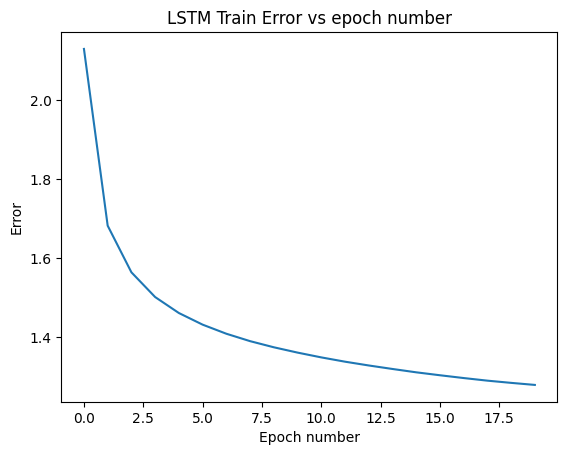

In [ ]:
import matplotlib.pyplot as plt
# Plot the error
plt.plot(re_lstm_basic, label='train')
plt.title('LSTM Train Error vs epoch number')
plt.xlabel('Epoch number')
plt.ylabel('Error')
plt.show()

In [ ]:
priming_sentences = ["I am trying to create synthetic language.",
                     "The weather is beautiful and warm today.",
                     "I am writing the Machine Learning homework"]

for priming_sentence in priming_sentences:
    print(f"Priming Sentence: {priming_sentence}")
    Synthesize("LSTM", priming_sentence)
    print()


Priming Sentence: I am trying to create synthetic language.
I am trying to create synthetic language.

PETRUCHIO:
There is that will be my steem
And not lights him.

Clown:
Ay, that will I do to tell t

Priming Sentence: The weather is beautiful and warm today.
The weather is beautiful and warm today.

KATHARINA:
A moning of your love, take your lady
To hide it to his brace and the blood
Which I wis

Priming Sentence: I am writing the Machine Learning homework
I am writing the Machine Learning homeworkingland and to themselves,
Who is most like to be done,
And see's the seals, the duke and the bank.




In [ ]:
test_loss_lstm = Tester("LSTM")

[39  5  1  7  1  0  4  7  1  0 15  3 13  0 20  3  9  8 20  0  2  3 12  4
 15 44]
num_batches 47
test loss: 1.433076764674897


### (b) Run the same experiment with the basic RNN architecture. This has 1/4 of the parameters of the LSTM. Compare the training error plot with the original LSTM. Compare the test set error.

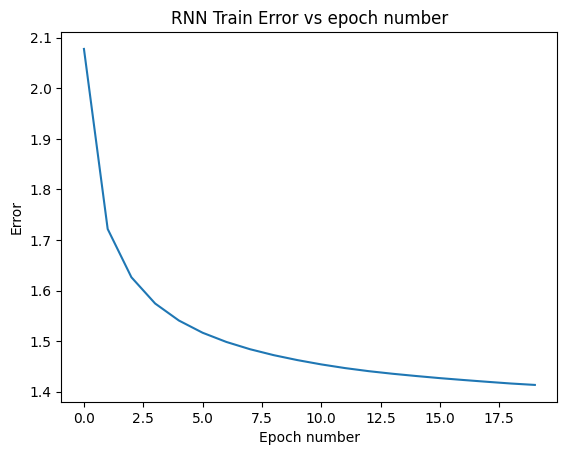

In [ ]:
# Plot the error
plt.plot(re_rnn_basic, label='train')
plt.title('RNN Train Error vs epoch number')
plt.xlabel('Epoch number')
plt.ylabel('Error')
plt.show()

In [ ]:
priming_sentences = ["I am trying to create synthetic language.",
                     "The weather is beautiful and warm today.",
                     "I am writing the Machine Learning homework"]

for priming_sentence in priming_sentences:
    print(f"Priming Sentence: {priming_sentence}")
    Synthesize("RNN", priming_sentence)
    print()

Priming Sentence: I am trying to create synthetic language.
I am trying to create synthetic language.

DUKE OF AUMERLE:
I would he be see it to be do not shall be daughter.

KING EDWARD IV:
What shall 

Priming Sentence: The weather is beautiful and warm today.
The weather is beautiful and warm today.

AUTOLYCUS:
An, I'll be hurt thou take it not tremal secutio are that I have a thing.

BRUTUS:
What

Priming Sentence: I am writing the Machine Learning homework
I am writing the Machine Learning homeworking on my some beggar, and this is my straitors of this secruties; and the cause
Believe you but mys



In [ ]:
test_loss_rnn = Tester("RNN")

[39  5  1  7  1  0  4  7  1  0 15  3 13  0 20  3  9  8 20  0  2  3 12  4
 15 44]
num_batches 47
test loss: 1.496725779898623


We see that the Error plot are pretty similar, both having an elbow around epoch 1 and the test loss is similar too, while the test loss for RNN is a bit higher than that of LSTM.

### (c) Try 3 alternatives. For example an RNN with the same number of parameters as the LSTM. Or an RNN with more than one internal layer. Explain each of your models, plot the training error rate functions as a function of epoch for all your models and show the error rates on the test set as well.

1. Increaseing the dimension of the hidden layer from $128\times2$ to $128\times4$

In [ ]:
print(device)
args.num_epochs=20
args.num_unit = 128*4
train_loss_rnn_dim = trainer("RNN")

cuda:0
train_num_batches 185
epoch: 0 loss: 2.0490100113121237
epoch: 1 loss: 1.6870605462306254
epoch: 2 loss: 1.5868770979546212
epoch: 3 loss: 1.5334261095201647
epoch: 4 loss: 1.4989686888617437
epoch: 5 loss: 1.4748062977919707
epoch: 6 loss: 1.4564088647430007
epoch: 7 loss: 1.4418658527168067
epoch: 8 loss: 1.4298063245979515
epoch: 9 loss: 1.4209399326427563
epoch: 10 loss: 1.4135972158328907
epoch: 11 loss: 1.4073002447953096
epoch: 12 loss: 1.402362441372227
epoch: 13 loss: 1.3980211837871654
epoch: 14 loss: 1.3926058169957753
epoch: 15 loss: 1.3884132320816454
epoch: 16 loss: 1.3842169942082585
epoch: 17 loss: 1.3819504583204114
epoch: 18 loss: 1.3800587447913917
epoch: 19 loss: 1.378176845730962
00 hours 03 minutes 08.04 seconds


In [ ]:
test_loss_rnn_layer2 = Tester("RNN")

[39  5  1  7  1  0  4  7  1  0 15  3 13  0 20  3  9  8 20  0  2  3 12  4
 15 44]
num_batches 47
test loss: 1.4639715032374605


2. RNN with more than one internal layer:

In [ ]:
# 2 Lyaer RNN Cell Class
class MyBasicRNNCell_2(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.W1 = nn.Parameter(torch.Tensor(input_size + hidden_size, hidden_size))
        self.b1 = nn.Parameter(torch.Tensor(hidden_size))
        self.W2 = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b2 = nn.Parameter(torch.Tensor(hidden_size))
        self.init_weights()
    def init_weights(self):
        for p in self.parameters():
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)
    def forward(self, x, init_states):
        h1 = torch.tanh(torch.cat((x, init_states), 1) @ self.W1 + self.b1)
        output = torch.tanh(h1 @ self.W2 + self.b2)
        return output, output


In [ ]:
class network_2(nn.Module):
    def __init__(self, cell_type, ntoken, ninp, nhid):
#       cell_type can be RNN or LSTM
#       notken should be args.num_chars
#       ninp should be args.num_units - it is the dimension of the embedding 
#       of the discrete tokens and it usually the same as the hidden dimension.
#       nhid should be args.num_units
        super(network_2, self).__init__()
        self.cell_type = cell_type
        if self.cell_type == 'LSTM':
            self.cell = MyBasicLSTMCell(args.num_units, args.num_units)

        elif self.cell_type == 'RNN':
            self.cell = MyBasicRNNCell_2(args.num_units, args.num_units)
            self.cell2 = MyBasicRNNCell_2(args.num_units, args.num_units)
        else:
            raise NotImplementedError
        self.ntoken = ntoken
        self.ninp = ninp
        self.nhid = nhid
        self.embedding = nn.Embedding(ntoken, ninp)
        self.decoder = nn.Linear(nhid, ntoken)
        self.init_weights()
        
    def init_weights(self):
        self.decoder.bias.data.zero_()

    def forward(self, x, hidden):
        bs, seq_sz = x.size()
        emb = self.embedding(x)
        assert hidden is not None
        outputs = []
        for t in range(seq_sz):
            x_t = emb[:,t,:]
            output, hidden = self.cell(x_t, hidden)
            #output, hidden = self.cell(output, hidden)
            outputs.append(output)
        reshaped_output = torch.cat(outputs,1).view(-1, self.nhid)
        logits = self.decoder(reshaped_output)
        logits = logits.view(bs,seq_sz,-1)
        final_hidden = hidden
        return logits, final_hidden

    def init_hidden(self, bsz):
        # external function
        weight = next(self.parameters()).data
        if self.cell_type == 'LSTM':
            return (weight.new_zeros(bsz, self.nhid),
                    weight.new_zeros(bsz, self.nhid))
        elif self.cell_type == 'RNN':
            return weight.new_zeros(bsz, self.nhid)
        else:
            raise NotImplementedError

In [ ]:
def trainer_2(celltype):
    criterion = nn.CrossEntropyLoss()
    start_time = time.time()
    my_network = network_2(celltype, args.num_chars, args.num_units, args.num_units).to(device)
    my_network.train()
    optimizer = torch.optim.Adam(my_network.parameters(), lr=args.lr)
    print('train_num_batches',loader.train_num_batches)
    
    num_batches=loader.train_num_batches
    training_losses = []
    for epoch in range(args.num_epochs):
        loader.reset_batch_pointer()
        # Initial state - 0
        init_state = my_network.init_hidden(args.batch_size)
        training_loss = 0

        for batch in range(num_batches):
            x, y = loader.next_batch_train()
            x = torch.from_numpy(np.int64(x)).to(device)
            y = Variable(torch.from_numpy(np.int64(y))).to(device)
            preds, final_hidden = my_network(x, init_state)
            train_loss_ = criterion(preds.reshape(-1, args.num_chars), y.reshape(-1))
            optimizer.zero_grad()
            train_loss_.backward()
            optimizer.step()
            training_loss += train_loss_.item()
        training_loss=training_loss/num_batches
        print('epoch:', epoch, 'loss:',  training_loss)
        training_losses.append(training_loss)
    torch.save(my_network.state_dict(), os.path.join(args.save_dir, f'saved_{celltype}_model.pt'))
    end_time = time.time()
    
    timer(start_time, end_time)
    return(training_losses)

In [ ]:
print(device)
args.num_epochs=20
re_rnn_layer2 = trainer_2("RNN")

cuda:0
train_num_batches 185
epoch: 0 loss: 2.054459412677868
epoch: 1 loss: 1.6917653032251307
epoch: 2 loss: 1.593915242762179
epoch: 3 loss: 1.543192905993075
epoch: 4 loss: 1.5106766662082156
epoch: 5 loss: 1.490291665695809
epoch: 6 loss: 1.473553193582071
epoch: 7 loss: 1.4613533754606505
epoch: 8 loss: 1.4527930904079127
epoch: 9 loss: 1.4460097080952412
epoch: 10 loss: 1.4407112985043913
epoch: 11 loss: 1.4383782908723162
epoch: 12 loss: 1.4369051308245273
epoch: 13 loss: 1.432896521929148
epoch: 14 loss: 1.42980948654381
epoch: 15 loss: 1.4331143920486038
epoch: 16 loss: 1.4325169975693162
epoch: 17 loss: 1.4383661643878833
epoch: 18 loss: 1.4411958713789244
epoch: 19 loss: 1.44126088876982
00 hours 05 minutes 15.66 seconds


In [ ]:
def Tester_2(celltype, num_batches=None):
    my_network = network_2(celltype, args.num_chars, args.num_units, args.num_units)
    my_network.load_state_dict(torch.load(os.path.join(args.save_dir, f'saved_{celltype}_model.pt')))
    my_network.eval()
    # Define initialization
    initialization = 'Where are you going today?'
    loader= TextLoader(args.data_dir, batch_size=args.batch_size, seq_length=args.num_steps)

    forecast_data=np.array(list(map(loader.vocab_to_idx.get, initialization)))
    print(forecast_data)
    forecast_range = 100
    top_k=5
 
    if (num_batches is None):
        num_batches=loader.test_num_batches
   
    state_ = my_network.init_hidden(args.batch_size)
    loader.reset_batch_pointer()
    # Get test error loss
    test_loss = 0
    print('num_batches',num_batches)
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for batch in range(num_batches):
            x, y = loader.next_batch_test()
            x = Variable(torch.from_numpy(np.int64(x)))
            y = Variable(torch.from_numpy(np.int64(y)))
            preds, final_hidden = my_network(x, state_)
            test_loss_ = criterion(preds.reshape(-1, args.num_chars), y.reshape(-1))
            test_loss += test_loss_.item()
        test_loss=test_loss/num_batches
        print('test loss:',  test_loss)
    
    return(test_loss)

In [ ]:
test_loss_layer2 = Tester_2("RNN")

1.7733005006262597

3. RNN with the same number of parameters as LSTM

In [209]:
class MyBasicRNNCell_3(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # RNN parameters
        self.W_xh = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.W_hh = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_h = nn.Parameter(torch.Tensor(hidden_size))

        # Additional LSTM-like parameters
        self.W_xc = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.W_hc = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_c = nn.Parameter(torch.Tensor(hidden_size))

        self.init_weights()

    def init_weights(self):
        for p in self.parameters():
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)

    def forward(self, x, init_states):
        h_t = init_states

        # RNN computation
        h = torch.tanh(x @ self.W_xh + h_t @ self.W_hh + self.b_h)

        # LSTM-like computation
        c = torch.tanh(x @ self.W_xc + h_t @ self.W_hc + self.b_c)

        return h, c


In [208]:
class network_3(nn.Module):
    def __init__(self, cell_type, ntoken, ninp, nhid):
#       cell_type can be RNN or LSTM
#       notken should be args.num_chars
#       ninp should be args.num_units - it is the dimension of the embedding 
#       of the discrete tokens and it usually the same as the hidden dimension.
#       nhid should be args.num_units
        super(network_3, self).__init__()
        self.cell_type = cell_type
        if self.cell_type == 'LSTM':
            self.cell = MyBasicLSTMCell(args.num_units, args.num_units)

        elif self.cell_type == 'RNN':
            self.cell = MyBasicRNNCell_3(args.num_units, args.num_units)
        else:
            raise NotImplementedError
        self.ntoken = ntoken
        self.ninp = ninp
        self.nhid = nhid
        self.embedding = nn.Embedding(ntoken, ninp)
        self.decoder = nn.Linear(nhid, ntoken)
        self.init_weights()
        
    def init_weights(self):
        self.decoder.bias.data.zero_()

    def forward(self, x, hidden):
        bs, seq_sz = x.size()
        emb = self.embedding(x)
        assert hidden is not None
        outputs = []
        for t in range(seq_sz):
            x_t = emb[:,t,:]
            output, hidden = self.cell(x_t, hidden)
            outputs.append(output)
        reshaped_output = torch.cat(outputs,1).view(-1, self.nhid)
        logits = self.decoder(reshaped_output)
        logits = logits.view(bs,seq_sz,-1)
        final_hidden = hidden
        return logits, final_hidden

    def init_hidden(self, bsz):
        # external function
        weight = next(self.parameters()).data
        if self.cell_type == 'LSTM':
            return (weight.new_zeros(bsz, self.nhid),
                    weight.new_zeros(bsz, self.nhid))
        elif self.cell_type == 'RNN':
            return weight.new_zeros(bsz, self.nhid)
        else:
            raise NotImplementedError

In [207]:
def trainer_3(celltype):
    criterion = nn.CrossEntropyLoss()
    start_time = time.time()
    my_network = network_3(celltype, args.num_chars, args.num_units, args.num_units).to(device)
    my_network.train()
    optimizer = torch.optim.Adam(my_network.parameters(), lr=args.lr)
    print('train_num_batches',loader.train_num_batches)
    
    num_batches=loader.train_num_batches
    training_losses = []
    for epoch in range(args.num_epochs):
        loader.reset_batch_pointer()
        # Initial state - 0
        init_state = my_network.init_hidden(args.batch_size)
        training_loss = 0

        for batch in range(num_batches):
            x, y = loader.next_batch_train()
            x = torch.from_numpy(np.int64(x)).to(device)
            y = Variable(torch.from_numpy(np.int64(y))).to(device)
            preds, final_hidden = my_network(x, init_state)
            train_loss_ = criterion(preds.reshape(-1, args.num_chars), y.reshape(-1))
            optimizer.zero_grad()
            train_loss_.backward()
            optimizer.step()
            training_loss += train_loss_.item()
        training_loss=training_loss/num_batches
        print('epoch:', epoch, 'loss:',  training_loss)
        training_losses.append(training_loss)
    torch.save(my_network.state_dict(), os.path.join(args.save_dir, f'saved_{celltype}_model.pt'))
    end_time = time.time()
    
    timer(start_time, end_time)
    return(training_losses)

In [ ]:
print(device)
args.num_epochs=20
train_loss_rnn_para2 = trainer_3("RNN")

cuda:0
train_num_batches 185
epoch: 0 loss: 2.001990875037941
epoch: 1 loss: 1.6459229424193098
epoch: 2 loss: 1.556723385888177
epoch: 3 loss: 1.508821995193894
epoch: 4 loss: 1.477719023421004
epoch: 5 loss: 1.4550898706590807
epoch: 6 loss: 1.4376172884090526
epoch: 7 loss: 1.4238671650757662
epoch: 8 loss: 1.412510052887169
epoch: 9 loss: 1.4029483543859946
epoch: 10 loss: 1.3946485893146412
epoch: 11 loss: 1.38747239821666
epoch: 12 loss: 1.3810540476360837
epoch: 13 loss: 1.3754697844788835
epoch: 14 loss: 1.3702227141406085
epoch: 15 loss: 1.365066452284117
epoch: 16 loss: 1.36056141208958
epoch: 17 loss: 1.3564126775071428
epoch: 18 loss: 1.353119294063465
epoch: 19 loss: 1.3504674801955352
00 hours 03 minutes 59.00 seconds


In [ ]:
def Tester_3(celltype, num_batches=None):
    my_network = network_3(celltype, args.num_chars, args.num_units, args.num_units)
    my_network.load_state_dict(torch.load(os.path.join(args.save_dir, f'saved_{celltype}_model.pt')))
    my_network.eval()
    # Define initialization
    initialization = 'Where are you going today?'
    loader= TextLoader(args.data_dir, batch_size=args.batch_size, seq_length=args.num_steps)

    forecast_data=np.array(list(map(loader.vocab_to_idx.get, initialization)))
    print(forecast_data)
    forecast_range = 100
    top_k=5
 
    if (num_batches is None):
        num_batches=loader.test_num_batches
   
    state_ = my_network.init_hidden(args.batch_size)
    loader.reset_batch_pointer()
    # Get test error loss
    test_loss = 0
    print('num_batches',num_batches)
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for batch in range(num_batches):
            x, y = loader.next_batch_test()
            x = Variable(torch.from_numpy(np.int64(x)))
            y = Variable(torch.from_numpy(np.int64(y)))
            preds, final_hidden = my_network(x, state_)
            test_loss_ = criterion(preds.reshape(-1, args.num_chars), y.reshape(-1))
            test_loss += test_loss_.item()
        test_loss=test_loss/num_batches
        print('test loss:',  test_loss)
    
    return(test_loss)

In [ ]:
test_loss_para2 = Tester_3("RNN")

[39  5  1  7  1  0  4  7  1  0 15  3 13  0 20  3  9  8 20  0  2  3 12  4
 15 44]
num_batches 47
test loss: 1.4718445438019774


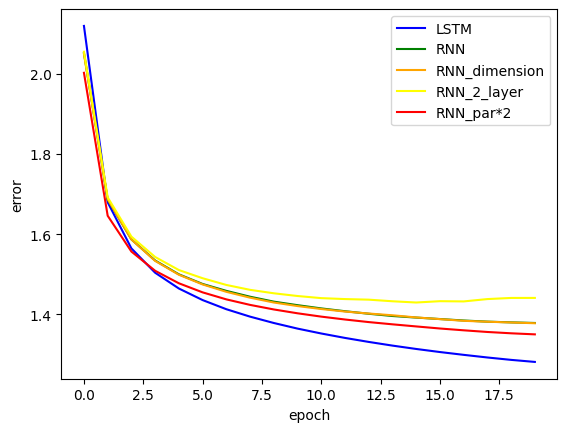

In [ ]:
fig, ax = plt.subplots()
xep = list(range(20))

ax.plot(xep, re_lstm_basic, color='blue', label='LSTM')
ax.plot(xep, re_rnn_basic, color='green', label='RNN')
ax.plot(xep, train_loss_rnn_dim, color='orange', label='RNN_dimension')
ax.plot(xep, re_rnn_layer2, color='yellow', label='RNN_2_layer')
ax.plot(xep, train_loss_rnn_para2, color='red', label='RNN_par*2')

ax.set_xlabel('epoch')
ax.set_ylabel('error')

ax.legend()
plt.show()

### (d) For each model, run a simulation starting with the same initialization text of your choice.

1. RNN with higher hidden dimension

In [212]:
Synthesize('RNN', "I like spring better than winter!")

I like spring better than winter!

ANGELO:
Which I speak,
And that, that they be but out an eased thee, and transt
Where was, and the


2. RNN with one more hidden layer

In [206]:
def Synthesize_2(celltype, init_string="None"):
    num_steps_bak=args.num_steps
    batch_size_bak=args.batch_size
    args.num_steps=1
    args.batch_size=1
    my_network = network_2(celltype, args.num_chars, args.num_units, args.num_units)
    my_network.load_state_dict(torch.load(os.path.join(args.save_dir, f'saved_{celltype}_model.pt')))
    my_network.eval()

    # Define initialization
    if (init_string is None):
        initialization = 'Where are you going today?'
    else:
        initialization = init_string
    loader= TextLoader(args.data_dir, batch_size=1, seq_length=1)

    forecast_data=np.array(list(map(loader.vocab_to_idx.get, initialization)))
    #print(forecast_data)
    forecast_range = 100
    top_k=5
 
    # Run rnn on initialization data to get final hidden state before simulation
    init_state = my_network.init_hidden(args.batch_size)
    #print('data length',forecast_data.shape[0])
    with torch.no_grad():
        for i in range(forecast_data.shape[0]):
            inputs = forecast_data[i].reshape(args.batch_size, args.num_steps)
            x = Variable(torch.from_numpy(np.int64(inputs)))
            _, state_ = my_network(x, init_state)

        # last state of this step becomes first state of simulation

        for i in range(forecast_range):
            # Feed current predicted
            inputs = forecast_data[-args.num_steps:].reshape(args.batch_size, args.num_steps)
            x = Variable(torch.from_numpy(np.int64(inputs)))
            logits_, state_ = my_network(x, state_)
            predicted_prob = F.softmax(logits_.reshape(-1, args.num_chars),1).detach().numpy().squeeze()
#             print(predicted_prob.shape)
            # Simulate from top top_k probs
            predicted_prob[np.argsort(predicted_prob)[:-top_k]] = 0
            predicted_prob = predicted_prob/np.sum(predicted_prob)
            sample = np.random.choice(args.num_chars, 1, p=predicted_prob)[0]
            forecast_data = np.hstack((forecast_data, sample))

    forecasted_chars = np.asarray([loader.idx_to_vocab[elem] for elem in forecast_data])

    print(''.join(forecasted_chars))
  
    args.num_steps=num_steps_bak
    args.batch_size=batch_size_bak

In [210]:
Synthesize_2("RNN", "I like spring better than winter!")

I like spring better than winter!

ANGELO:
The cordial shame,
And by the post in time to the perfiction of my best thou hast thought 


3. RNN with more parameters

In [205]:
def Synthesize_3(celltype, init_string="None"):
    num_steps_bak=args.num_steps
    batch_size_bak=args.batch_size
    args.num_steps=1
    args.batch_size=1
    my_network = network_3(celltype, args.num_chars, args.num_units, args.num_units)
    my_network.load_state_dict(torch.load(os.path.join(args.save_dir, f'saved_{celltype}_model.pt')))
    my_network.eval()

    # Define initialization
    if (init_string is None):
        initialization = 'Where are you going today?'
    else:
        initialization = init_string
    loader= TextLoader(args.data_dir, batch_size=1, seq_length=1)

    forecast_data=np.array(list(map(loader.vocab_to_idx.get, initialization)))
    #print(forecast_data)
    forecast_range = 100
    top_k=5
 
    # Run rnn on initialization data to get final hidden state before simulation
    init_state = my_network.init_hidden(args.batch_size)
    #print('data length',forecast_data.shape[0])
    with torch.no_grad():
        for i in range(forecast_data.shape[0]):
            inputs = forecast_data[i].reshape(args.batch_size, args.num_steps)
            x = Variable(torch.from_numpy(np.int64(inputs)))
            _, state_ = my_network(x, init_state)

        # last state of this step becomes first state of simulation

        for i in range(forecast_range):
            # Feed current predicted
            inputs = forecast_data[-args.num_steps:].reshape(args.batch_size, args.num_steps)
            x = Variable(torch.from_numpy(np.int64(inputs)))
            logits_, state_ = my_network(x, state_)
            predicted_prob = F.softmax(logits_.reshape(-1, args.num_chars),1).detach().numpy().squeeze()
#             print(predicted_prob.shape)
            # Simulate from top top_k probs
            predicted_prob[np.argsort(predicted_prob)[:-top_k]] = 0
            predicted_prob = predicted_prob/np.sum(predicted_prob)
            sample = np.random.choice(args.num_chars, 1, p=predicted_prob)[0]
            forecast_data = np.hstack((forecast_data, sample))

    forecasted_chars = np.asarray([loader.idx_to_vocab[elem] for elem in forecast_data])

    print(''.join(forecasted_chars))
  
    args.num_steps=num_steps_bak
    args.batch_size=batch_size_bak

In [ ]:
Synthesize_3("RNN","I like spring better than winter!")

I like spring better than winter!

ANGELO:
Save to have stand with thee and son:
I do boy, to breathe an exild at our point,
Since th


# Question 2 Classifying spoken digits

### (a) Experiment with some of the RNN cells you used for the previous problem to process the speech data. The loss now is different. It is not predicting the data in the next time-step but just predicting the label of the utterance based on the value of the hidden layer at the last time-step. Report the results.

In [ ]:
with open(datadir+'SOUND_DATA_A', 'rb') as f: 
    data_voice = pickle.load(f)

In [ ]:
data_voice.keys()

dict_keys(['X_train_mfcc', 'X_train', 'Y_train', 'X_test_mfcc', 'X_test', 'Y_test', 'X_valid_mfcc', 'X_valid', 'Y_valid'])

In [ ]:
x_train = data_voice['X_train_mfcc']
y_train = data_voice['Y_train']

In [ ]:
class Voice_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.rnn_cell = MyBasicRNNCell(input_size, hidden_size)
        self.classifier = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x, h0):
        hn = h0
        for t in range(10):
            hn, _ = self.rnn_cell(x[:, t, :], hn)
        output = self.classifier(hn)
        return output
        

In [ ]:
def voice_trainer(model, epochs):
    hidden_size = 256
    num_classes = 10
    batch_size = 60
    num_batches = 25

    num_batches = 25
    x_train_batches = torch.chunk(torch.tensor(x_train), num_batches, dim=0)
    y_train_batches = torch.chunk(torch.tensor(y_train), num_batches, dim=0)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss() # loss function
    model.train()
    loss = []

    # Train the model
    for epoch in range(epochs):
        epoch_loss = 0
        total_correct = 0
        total_samples = 0
        for i in range(len(x_train_batches)):
            inputs = x_train_batches[i]
            labels = y_train_batches[i].squeeze()
            
            # zero the gradients
            optimizer.zero_grad()

            # Initialize hidden states
            h = torch.zeros(batch_size, hidden_size) # can change init

            # forward pass
            logits = model(inputs, h)

            # compute loss and backward pass
            loss = loss_fn(logits, labels.long())
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
    
        epoch_loss = epoch_loss / num_batches
        if epoch % 5 == 0:
            print('epoch:', epoch, 'loss:',  epoch_loss) 
        if epoch == (epochs-1): 
            print('epoch:', epoch, 'loss:',  epoch_loss)

In [ ]:
model = Voice_RNN(64, 256, 10)
voice_trainer(model, epochs = 100)

epoch: 0 loss: 3.1307430267333984
epoch: 5 loss: 2.3601307344436644
epoch: 10 loss: 2.1620175886154174
epoch: 15 loss: 2.11021909236908
epoch: 20 loss: 1.85257022857666
epoch: 25 loss: 1.6375627708435059
epoch: 30 loss: 1.500589280128479
epoch: 35 loss: 1.1860923552513123
epoch: 40 loss: 1.3541005635261536
epoch: 45 loss: 0.9417175996303558
epoch: 50 loss: 0.843777921795845
epoch: 55 loss: 0.8760370314121246
epoch: 60 loss: 0.5260914772748947
epoch: 65 loss: 0.6304879599809646
epoch: 70 loss: 0.5556824183464051
epoch: 75 loss: 0.22135214939713477
epoch: 80 loss: 0.10782133087515831
epoch: 85 loss: 0.07094825733453035
epoch: 90 loss: 0.05179037395864725
epoch: 95 loss: 0.03998998994007707
epoch: 99 loss: 0.03349456150084734


### (b) As an alternative, try simply training some of the standard linear classifiers in scikit-learn on the input 640 dimensional data. How do the results compare to the RNN results?

In [ ]:
x_train.shape
x_train_rsp = x_train.reshape(1500,10*64)

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

model = LogisticRegression()
model.fit(x_train_rsp, y_train)
y_train_pred = model.predict_proba(x_train_rsp)

train_loss = log_loss(y_train, y_train_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
print("Training loss:", train_loss)

Training loss: 0.008094912863260823


### (c) What is your conclusion from the comparison between the two approaches to classification.

We see that using Linear classifier (here we use logistic regression) generates a smaller training loss than RNN with 100 epoches. It might be that RNN could perform better if we decide to further increase the number of epoches but it will take more computational power and longer time.